# Прогнозирование выручки придорожного кафе

![foto](https://ruskafe.ru/media/images/site/foto_main_d5d58nW.JPG)

## Введение. Постановка целей и задач.

Цель любой предпринимательской деятельности - получение прибыли.  
Введение различных ограничений в связи с эпидемиологической обстановкой оказывает влияние на все сферы бизнеса, особенно на предприятия в сфере общепита. Оценка и прогнозирование выручки в данной ситуации принимает особо важное значение.  
Выбранное кафе находится на трассе Тимашевск - Славянск-на-Кубани и ведет свою деятельность в условиях жесткой конкуренции. На участке дороги, протяженностью 4 км, находятся 10 придорожных кафе и 10 продуктовых магазинов.  
Наша цель - оценить финансовые поступления предприятия в текущем и будущем периоде в условиях пандемии короновирусной инфекции и существующей конкуренции.  
Задача - провести анализ выручки придорожного кафе и построить прогноз выручки на предстоящий период.

## Импорт библиотек, ознакомление с данными.

### Импорт данных, библиотек.

In [1]:
## импортируем библиотеки и функции
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#sns.set()
from pylab import rcParams
import datetime

import warnings
warnings.filterwarnings('ignore')
 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.api import ExponentialSmoothing
from prophet import Prophet

# метрики
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Задаем некоторые опции библиотеки pandas, которые 
# настраивают вывод
pd.set_option('display.max_columns', 70)
pd.set_option('display.max_rows', 10)
#pd.set_option('display.width', 80)

In [2]:
## импортируем данные.
df = pd.read_csv('cafe.csv')

In [3]:
## проверка размера загруженных данных.
'Датафрейм содержит: {} строк и {} столбцов'.format(df.shape[0], df.shape[1])

'Датафрейм содержит: 715 строк и 9 столбцов'

In [4]:
df.tail(2)

,date,colkas,sumkas,colbez,sumbez,colskid,sumskid,colkredit,sumkredit
713,2022-03-01,63.0,25581.0,46.0,15397.8,28.0,1492.4,0.0,0.0
714,2022-03-02,49.0,21830.0,42.0,15875.0,32.0,1525.1,0.0,0.0


### Знакомство с данными.

Параметры полученного датафрейма

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       715 non-null    object 
 1   colkas     715 non-null    float64
 2   sumkas     715 non-null    float64
 3   colbez     715 non-null    float64
 4   sumbez     715 non-null    float64
 5   colskid    715 non-null    float64
 6   sumskid    715 non-null    float64
 7   colkredit  715 non-null    float64
 8   sumkredit  715 non-null    float64
dtypes: float64(8), object(1)
memory usage: 50.4+ KB


Полученный файл содержит данные о кассовой выручке за последние 2 года.
Датафрейм содержит 9 полей:
 - **date** - дата
 - **colkas** - количество операций за наличный расчет
 - **sumkas** - сумма операций за наличный расчет
 - **colbez** - количество операций по карте
 - **sumbez** - сумма операций по карте
 - **colskid** - количество предоставленных скидок
 - **sumskid** - сумма предоставленных скидок
 - **colkredit** - количество операций в кредит или по договору
 - **sumkredit** - сумма операций в кредит или по договору


### Вывод по этапу

Загружены необходимые библиотеки. Полученный файл загружен в Pandas DataFrame. Датафрейм содержит 9 полей, среди них одно текстовое поле с датой и 8 - с числами с плавающей запятой, отображающие количество и сумму касссовых операций за текущую дату.

## Предобработка данных

### Фильтрация данных

Для анализа выберем поля: дата, сумма операций за наличный расчет, по карте и в кредит.

In [6]:
df = df[['date','sumkas','sumbez','sumkredit']]
df.rename(columns={'sumkas':'наличные', 
                    'sumbez':'электронно',
                    'sumkredit':'кредит'}, inplace=True)
df.head()

,date,наличные,электронно,кредит
0,2020-02-27,22867.0,7394.0,0.0
1,2020-02-28,22088.0,8237.2,0.0
2,2020-02-29,22214.0,7065.0,0.0
3,2020-03-01,23544.0,4668.0,0.0
4,2020-03-02,17528.0,8849.0,0.0


### Обработка пропусков

In [7]:
# Определение временных границ датафрейма
df['date'] = pd.to_datetime(df.date) # перевод даты в формат datetime
start_date = df.date.min()
end_date = df.date.max()
print('Период представленных данных с {} по {}'.format(start_date, end_date))

Период представленных данных с 2020-02-27 00:00:00 по 2022-03-02 00:00:00


In [8]:
# Определение количества пропущенных дней
date_range = pd.date_range(start=df.date.min(), end=df.date.max(), freq='D')
print('Пропущено дней в индексе: ', len(date_range[~date_range.isin(df.date)]))

Пропущено дней в индексе:  20


In [9]:
# список пропущенных дней
date_range[~date_range.isin(df.date)]

DatetimeIndex(['2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-05-06',
               '2020-12-31', '2021-01-01', '2021-01-02', '2021-01-07',
               '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02'],
              dtype='datetime64[ns]', freq=None)

In [10]:
# восстановление пропусков дат
df1 = date_range.to_frame(index=True, name='date')
df = df1.merge(df, how='outer', left_on='date', right_on='date')

In [11]:
# Проверка пропусков в данных
df.isna().sum()

date           0
наличные      20
электронно    20
кредит        20
dtype: int64

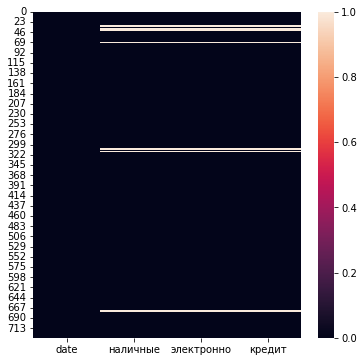

In [12]:
# Визуальная оценка отсутствующих данных
plt.figure(figsize=(6,6))
sns.heatmap(df.isnull());

Данные остутствуют в те дни, когда кафе не работало по причине введенных ограничений или праздничные дни в новогодние каникулы.
Все пропущенные значения можно заменить на 0.

In [13]:
df.fillna(0, inplace=True)
df.isna().sum()

date          0
наличные      0
электронно    0
кредит        0
dtype: int64

In [14]:
df.tail(3)

,date,наличные,электронно,кредит
732,2022-02-28,23788.0,17679.8,0.0
733,2022-03-01,25581.0,15397.8,0.0
734,2022-03-02,21830.0,15875.0,0.0


### Вывод по этапу.


Обработаны данные за 735 дней работы придорожного кафе. Датафрейм содержал пропуски, которые были благополучно обработаны. Временной ряд готов для проведения дальнейшего анализа.

## EDA или разведочный анализ данных.

### Индексирование датафрейма

In [15]:
# установка даты в качестве индекса
df.set_index('date', inplace=True)

### Обзор статистики значений признаков

In [16]:
df.describe()

,наличные,электронно,кредит
count,735.000000,735.000000,735.00000
mean,26437.636735,15307.270680,151.90517
std,11830.153905,10634.143468,457.47310
min,0.000000,0.000000,0.00000
25%,19484.500000,8162.500000,0.00000
50%,25849.000000,12862.600000,0.00000
75%,32409.000000,19754.650000,50.00000
max,69595.000000,63837.800000,8555.60000


Экстремальные значения в пределах нормы, отрицательных значений не обнаружено.

### Визуальное представление данных.

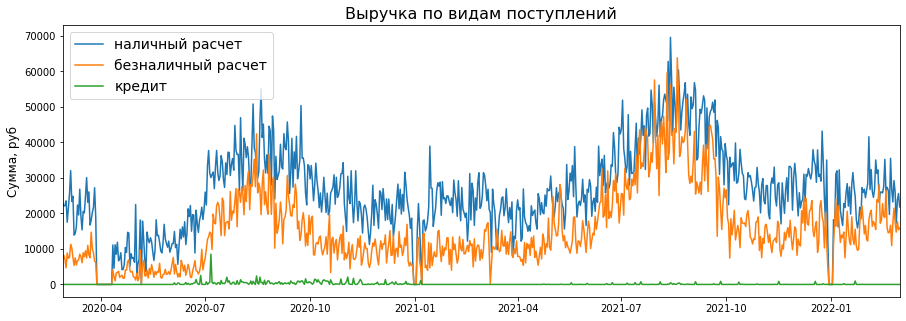

In [17]:
plt.figure(figsize = (15,5))
plt.plot(df['наличные'], label = 'наличный расчет')
plt.plot(df['электронно'], label = 'безналичный расчет')
plt.plot(df['кредит'], label = 'кредит')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('Выручка по видам поступлений', fontsize = 16)
plt.autoscale(axis='x',tight=True)
plt.show();

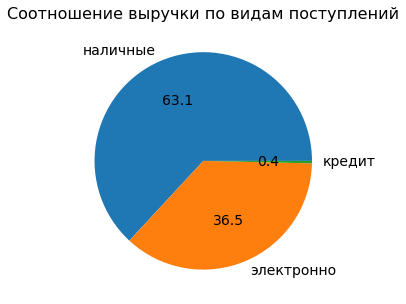

In [18]:
df_sum = df.sum()
df_sum.name = ''
df_sum.plot.pie(autopct="%.1f",fontsize = 14,figsize = (5,5))
plt.title('Соотношение выручки по видам поступлений', fontsize = 16);
#plt.legend(loc='upper left', bbox_to_anchor=(0.9, 0.9), fontsize=14);

Сумма наличных оплат составляет приблизительно 2/3 от общей суммы выручки.

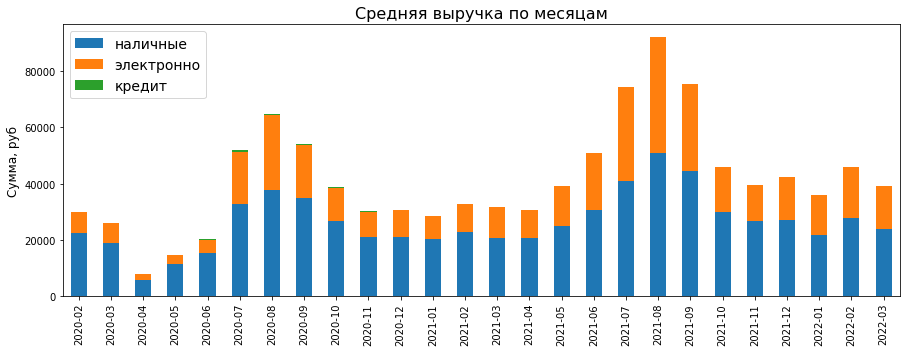

In [19]:
dfm = df.resample('M', kind='period').mean()
dfm.plot.bar(figsize = (15,5), stacked=True)
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('Средняя выручка по месяцам', fontsize = 16);

На июль, август и сентябрь приходится максимальная выручка в течение года.

### Выбор анализируемых параметров

Для анализа поступлений, требуется сумма выручки из всех источников.

In [20]:
dfs = df['наличные'] + df['электронно'] + df['кредит']

### Статистика итогового распределения

In [21]:
dfs.describe()

count       735.000000
mean      41896.812585
std       21481.854045
min           0.000000
25%       29160.250000
50%       38824.800000
75%       52361.950000
max      126438.500000
dtype: float64

Средняя выручка составила 41897 рублей, медианное значение - 38825 рублей, максимальная выручка в день - 126438 рублей.

### Визуализация анализируемого временного ряда

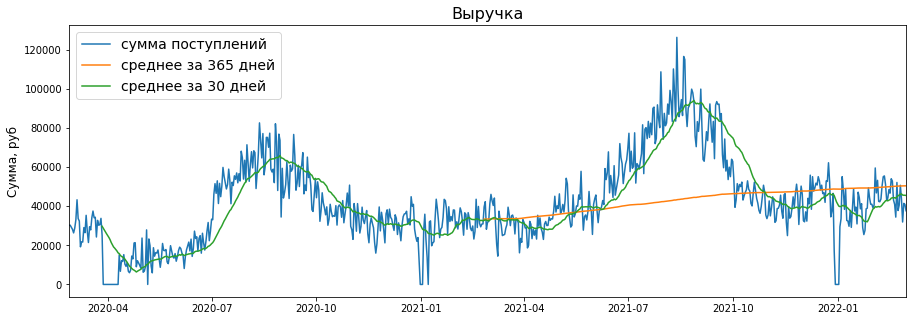

In [22]:
plt.figure(figsize = (15,5))
plt.plot(dfs, label='сумма поступлений')
plt.plot(dfs.rolling(window = 365).mean(), label = 'среднее за 365 дней')
plt.plot(dfs.rolling(window = 30).mean(), label = 'среднее за 30 дней')
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('Выручка', fontsize = 16)
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.autoscale(axis='x',tight=True)
plt.show();

### Выводы по этапу

Средняя выручка за 365 дней находится в районе 40000 рублей. Наблюдаются еженедельные, ежегодные колебания выручки и небольшой восходящий тренд. В июле, августе и сентябре наблюдается максимальная средняя выручка. Около 2/3 поступлений денежных средств происходит в наличной форме.  
Полученный итоговый временной ряд готов для прогнозирования.

## Построение моделей, анализ результатов.

### Оценка параметров временного ряда

#### Проверка временного ряда на стационарность с использованием обобщенного теста Дики-Фуллера.  
Гипотеза H$_0$ - временной ряд не стационарен.

In [23]:
adf_test = adfuller(dfs)
res = '- отвергаем H0, процесс стационарный' if adf_test[1] < 0.05 else '- не отвергаем H0, процесс нестационарный'
print('p-value = ' + str(adf_test[1]), res)

p-value = 0.2674420691400373 - не отвергаем H0, процесс нестационарный


#### Взятие первой разности ряда и проверка её на стационарность

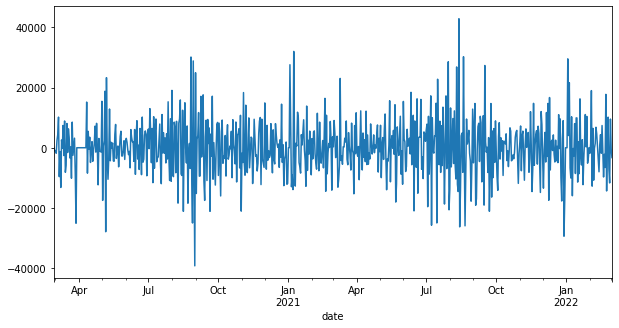

In [24]:
df_diff = dfs.diff(periods=1).dropna()
rcParams['figure.figsize'] = 10, 5
df_diff.plot();

In [25]:
# проверка первой разности на стационарность
adf_test = adfuller(df_diff)
res = '- отвергаем H0, процесс стационарный' if adf_test[1] < 0.05 else '- не отвергаем H0, процесс нестационарный'
print('p-value = ' + str(adf_test[1]), res)

p-value = 7.763747113985728e-12 - отвергаем H0, процесс стационарный


Нестационарность не обнаружена, следовательно наш ряд - интегрированный ряд первого порядка. Коэффициент d = 1.  
#### Построение автокорреляционной функции ACF.

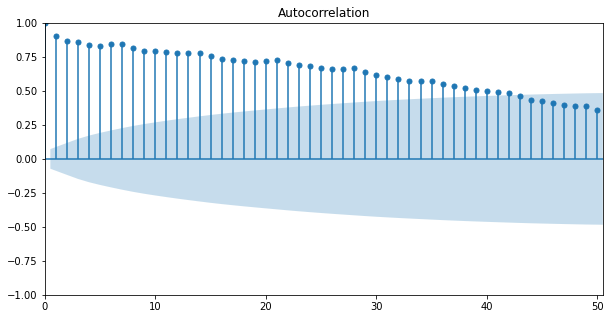

In [26]:
plot_acf(dfs, lags=50)
plt.autoscale(axis='x',tight=True);

По коррелограмме определен номер лага с максимальной корреляцией. Он будет коэффициентом MA(q) в модели ARIMA при ручном определении параметров. q=1.   
#### Построение частично автокорреляционной функции PACF

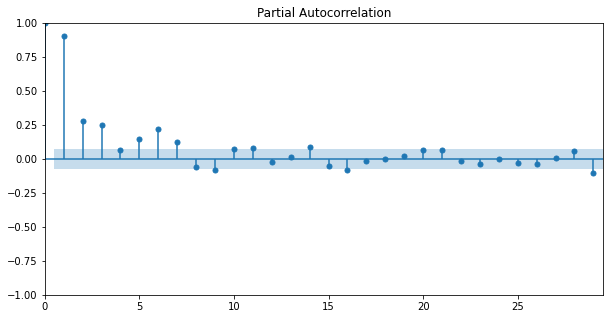

In [27]:
plot_pacf(dfs)
plt.autoscale(axis='x',tight=True);

По коррелограмме определен номер лага с максимальной корреляцией. Он будет коэффициентом AR(p) в модели ARIMA при ручном подборе параметров. p=1.  
#### Проведение декомпозиции временного ряда.

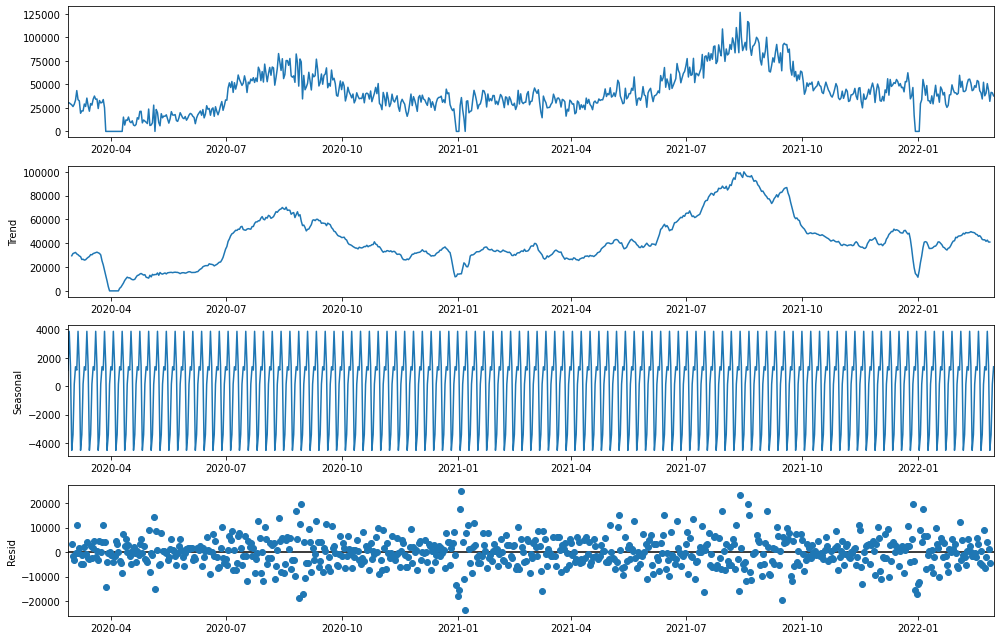

In [28]:
rcParams['figure.figsize'] = 14, 9
decompose = seasonal_decompose(dfs)
decompose.plot()
plt.show();

На основании графика определена сезонность - 7дней, имеется небольшой среднегодовой восходящий тренд а также прослеживается годовая цикличность. Остатки носят случайный характер, но имеют большой разброс. 

### Разделение датафрейма на тренировочный и тестовый набор.   
Для теста выбраны последние 14 дней.

In [29]:
train = dfs.iloc[:-14]
test = dfs.iloc[-14:]

### Модель SARIMA

Авторегрессионное интегрированное скользящее среднее или ARIMA - это метод прогнозирования для одномерных данных временных рядов.  
Он поддерживает элементы авторегрессии и скользящего среднего. Интегрированный элемент относится к разнице, позволяющей методу поддерживать данные временных рядов с помощью тренда.  
Сезонное авторегрессионное интегрированное скользящее среднее, SARIMA или Seasonal ARIMA, является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом.  
Он добавляет три новых гиперпараметра для указания авторегрессии (AR), разности (I) и скользящего среднего (MA) для сезонной составляющей ряда, а также дополнительный параметр для периода сезонности.  

#### Автоматический подбор параметров модели

In [30]:
auto_arima(train, seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  721
Model:             SARIMAX(1, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -7514.678
Date:                           Thu, 10 Mar 2022   AIC                          15041.356
Time:                                   16:58:54   BIC                          15068.832
Sample:                                        0   HQIC                         15051.964
                                           - 721                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5262      0.143      3.692      0.000       0.247       0.806
ma.L1         -1.0028      0.151     -6.648      0.000      -1.299      -0.707
ma.L2          0.1372      0.100      1.366      0.172      -0.060       0.334
ma.S.L7        0.1271      0.040      3.141      0.002       0.048       0.206
ma.S.L14       0.1033      0.037      2.791      0.005       0.031       0.176
sigma2       7.03e+07   2.93e-10    2.4e+17      0.000    7.03e+07    7.03e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                96.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+34. Standard errors may be unstable.
"""

#### Обучение  модели SARIMA (1, 1, 2)x(0, 0, 2, 7)

In [31]:
model_sarima = SARIMAX(train, order=(1, 1, 2), seasonal_order=(0, 0, 2, 7), freq = 'D')
results_sarima = model_sarima.fit()
results_sarima.summary()

/home/ruskafe/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  721
Model:             SARIMAX(1, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -7514.678
Date:                           Thu, 10 Mar 2022   AIC                          15041.356
Time:                                   16:58:55   BIC                          15068.832
Sample:                               02-27-2020   HQIC                         15051.964
                                    - 02-16-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5262      0.143      3.692      0.000       0.247       0.806
ma.L1         -1.0028      0.151     -6.648      0.000      -1.299      -0.707
ma.L2          0.1372      0.100      1.366      0.172      -0.060       0.334
ma.S.L7        0.1271      0.040      3.141      0.002       0.048       0.206
ma.S.L14       0.1033      0.037      2.791      0.005       0.031       0.176
sigma2       7.03e+07   2.93e-10    2.4e+17      0.000    7.03e+07    7.03e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                96.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+34. Standard errors may be unstable.
"""

#### Прогнозирование SARIMA тестовой выборки

In [32]:
start=len(train)
end=len(train)+13
predict_sarima = results_sarima.predict(start=start, end=end, dynamic=False)

#### Визуализация предсказания SARIMA 

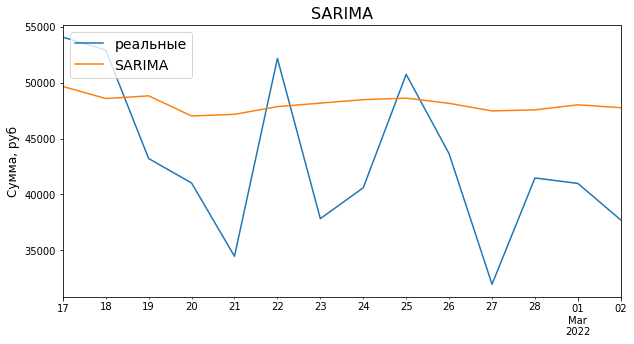

In [33]:
plt.figure(figsize = (10,5))
test.plot(label='реальные')
plt.plot(predict_sarima, label = 'SARIMA')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('SARIMA', fontsize = 16)
plt.autoscale(axis='x',tight=True)
plt.show();

#### Метрики ошибок предсказания

In [34]:
mape_sarima = mean_absolute_percentage_error(test, predict_sarima)
mse_sarima = mean_squared_error(test, predict_sarima)
rmse_sarima = rmse(test, predict_sarima)
print(f'MAPE:               {mape_sarima:11.10}')
print(f'MSE:                {mse_sarima:11.10}')
print(f'RMSE:               {rmse_sarima:11.10}')

MAPE:               0.1841254929
MSE:                65007278.45
RMSE:               8062.709126


### Тройное экспоненциальное сглаживание (Хольта-Винтерса)

Экспоненциальное сглаживание Холта-Винтера, названное в честь двух его авторов – Чарльза Холта (Charles Holt) и Питера Винтера (Peter Winter), является одним из старейших методов анализа временных рядов, который учитывает тенденции и сезонность при прогнозировании. Этот метод имеет три основных аспекта: среднее значение с учетом тренда и сезонности. Эти три аспекта представляют собой три типа экспоненциального сглаживания, поэтому метод также известен как тройное экспоненциальное сглаживание.

#### Построение прогнозной модели

In [35]:
model_3 = ExponentialSmoothing(train,
                               freq = 'D',
                               seasonal_periods=7, 
                               trend='add', 
                               seasonal='add',
                               damped_trend=True,
                               initialization_method="estimated").fit()

/home/ruskafe/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Прогнозирование тестовой выборки

In [36]:
predict_3 = model_3.forecast(14)

#### Визуализация предсказания Хольта-Винтерса

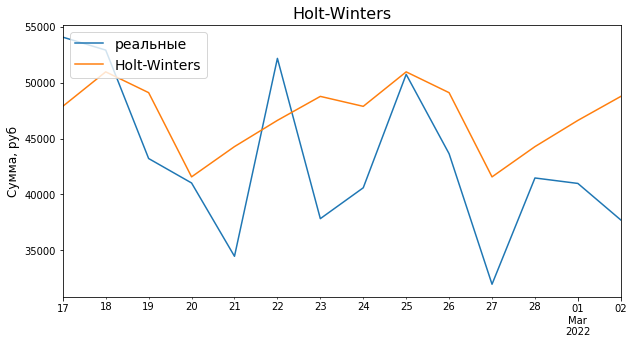

In [37]:
plt.figure(figsize = (10,5))
test.plot(label='реальные')
predict_3.plot(label='Holt-Winters')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('Holt-Winters', fontsize = 16)
plt.autoscale(axis='x',tight=True)
plt.show();

#### Метрики ошибок предсказания

In [38]:
mape_3 = mean_absolute_percentage_error(test, predict_3)
mse_3 = mean_squared_error(test, predict_3)
rmse_3 = rmse(test, predict_3)
print(f'MAPE:         {mape_3:11.10}')
print(f'MSE:         {mse_3:11.10}')
print(f'RMSE:         {rmse_3:11.10}')

MAPE:         0.1494773923
MSE:         47354806.43
RMSE:         6881.482865


### Prophet

Prophet — библиотека с открытым исходным кодом от компании Facebook. По словам разработчиков (команды Core Data Science team) она хорошо работает с временными рядами, которые имеют ярко выраженные сезонные эффекты, а также имеют несколько таких периодов. Prophet устойчив к отсутствию данных и достаточно хорошо справляется с выбросами.

#### Подготовка тестовой и обучающей выборки Prophet

In [39]:
df2 = pd.DataFrame(dfs)
df2['ds'] = df2.index
df2.rename(columns={0:'y'}, inplace=True)
train_2 = df2[:-14]
test_2 = df2[-14:]

#### Создание и обучение модели

In [40]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(train_2)

#### Прогнозирование тестовой выборки

In [41]:
future = m.make_future_dataframe(periods=14, freq='D')
forecast = m.predict(future)

#### Визуализация предсказания Prophet

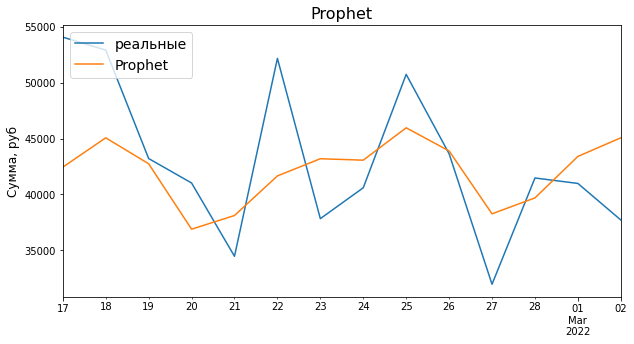

In [42]:
forecast.set_index('ds', inplace=True)
plt.figure(figsize = (10,5))
test.plot(label='реальные')
forecast.yhat[-14:].plot(label='Prophet')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('Prophet', fontsize = 16)
plt.autoscale(axis='x',tight=True)
plt.show();

#### Метрики ошибок предсказания

In [43]:
mape_p = mean_absolute_percentage_error(test_2.y, forecast.yhat.iloc[-14:])
mse_p = mean_squared_error(test_2.y, forecast.yhat.iloc[-14:])
rmse_p = rmse(test_2.y, forecast.yhat.iloc[-14:])
print(f'MAPE:             {mape_p:11.10}')
print(f'MSE:              {mse_p:11.10}')
print(f'RMSE:             {rmse_p:11.10}')

MAPE:             0.112958284
MSE:              35723728.14
RMSE:             5976.933005


### Графическое сравнение прогнозов

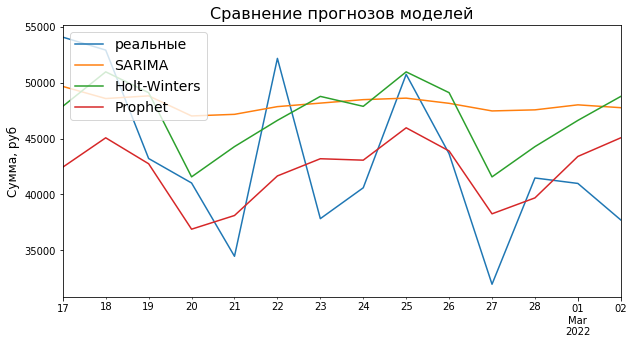

In [44]:
plt.figure(figsize = (10,5))
test.plot(label='реальные')
plt.plot(predict_sarima, label = 'SARIMA')
predict_3.plot(label='Holt-Winters')
forecast.yhat[-14:].plot(label='Prophet')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('Сравнение прогнозов моделей', fontsize = 16)
plt.autoscale(axis='x',tight=True)
plt.show();

###  Сравнение ошибок прогнозирования моделей

In [45]:
print(f'MAPE:')
print(f'    SARIMA:               {mape_sarima:11.10}')
print(f'    Holt-Winters:         {mape_3:11.10}')
print(f'    Prophet:              {mape_p:11.10}')
print(f'MSE:')
print(f'    SARIMA:               {mse_sarima:11.10}')
print(f'    Holt-Winters:         {mse_3:11.10}')
print(f'    Prophet:              {mse_p:11.10}')
print(f'RMSE:')
print(f'    SARIMA:               {rmse_sarima:11.10}')
print(f'    Holt-Winters:         {rmse_3:11.10}')
print(f'    Prophet:              {rmse_p:11.10}')

MAPE:
    SARIMA:               0.1841254929
    Holt-Winters:         0.1494773923
    Prophet:              0.112958284
MSE:
    SARIMA:               65007278.45
    Holt-Winters:         47354806.43
    Prophet:              35723728.14
RMSE:
    SARIMA:               8062.709126
    Holt-Winters:         6881.482865
    Prophet:              5976.933005


Библиотека Prophet показала лучшие результаты прогнозирования на тестовом массиве данных. 
Этот метод будет использован для построения прогноза выручки на 14 дней.

### Прогноз выручки на предстоящие 14 дней

#### Переобучение на полных данных

In [46]:
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.fit(df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Предсказание будущего периода

In [47]:
future = m.make_future_dataframe(periods=14, freq='D')
forecast = m.predict(future)
forecast.set_index('ds', inplace=True)

#### Визуальное представление предсказания

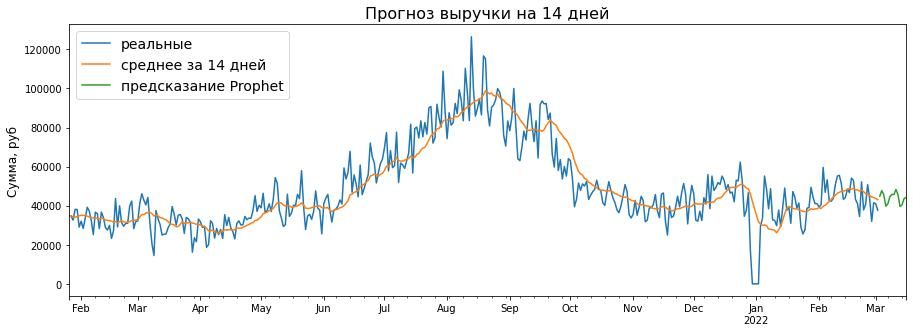

In [48]:
plt.figure(figsize = (15,5))
dfs[-400:].plot(label='реальные')
plt.plot(dfs[-414:].rolling(window = 14).mean(), label = 'среднее за 14 дней')
forecast.yhat[-14:].plot(label = 'предсказание Prophet')
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.xlabel('')
plt.ylabel('Сумма, руб', fontsize = 12)
plt.title('Прогноз выручки на 14 дней', fontsize = 16)
plt.autoscale(axis='x',tight=True)
plt.show();

### Выводы по этапу  
Проведена оценка временного ряда. Установлено,что это нестационарный интегрированный ряд первого порядка. Имеет сезонность длительностью 7 дней и ежегодную цикличность.  
На основании этого выбраны модели для прогнозирования SARIMA, тройное экспоненциальное сглаживание Хольта-Винтерса и библиотека Prophet.  
Модели построены и произведено прогнозирование на тестовой выборке. При сравнительном анализе выбрана библиотека Prophet для прогнозирования предстоящих периодов, как показавшая наименьшую ошибку прогнозирования.  
Произведено прогнозирование с помощью библиотеки Prophet, результат выведен на график.

## Выводы

Проведен анализ финансовых поступлений придорожного кафе. Построен прогноз на предстоящие 14 дней. Прогнозируемая выручка находится в районе среднегодовых показателей, то есть около 40000 рублей.  
Полученный прогноз соответствует ежегодному сезонному колебанию выручки.  
На размер выручки влияет множество других факторов, которые нет возможности учесть при анализе. Это такие как вводимые ограничения при повышении эпидемиологической опасности, открытие придорожных сетевых магазинов Магнит, Пятерочка, Светофор, конкуренция с другими предприятиями общепита, дорожные работы на трассе, ограничивающие транспортный поток или подъезд к кафе, аварийные или плановые отключения электроэнергии.  
Также на выручку влияет тип самих посетителей, постоянные или случайные, и сложившееся у них впечатление о качестве блюд и обслуживании персонала.  
Все эти неучитываемые факторы, влияющие и на конкурентов, могут оказать на выручку как отрицательное так и положительное действие. Поэтому построить долгосрочный прогноз не представляется возможным, а к полученным прогнозным данным надо относиться с определенной степенью доверия.